In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from systems.connectors import Pipe, Valve, Bend
from systems.pump import Pump
from systems.processors import Fermentation, Filtration, Distillation, Dehydration
from systems.facility import Facility

# Reload modules to ensure latest code
import importlib
import sys
for module_name in list(sys.modules.keys()):
    if module_name.startswith('systems'):
        del sys.modules[module_name]

from systems.connectors import Pipe, Valve, Bend
from systems.pump import Pump
from systems.processors import Fermentation, Filtration, Distillation, Dehydration
from systems.facility import Facility

print("Imports complete")

Imports complete


# Ethanol Plant Model - Process Alternative Testing

## Target: 100,000 gallons/day ethanol output

Metrics:
- Total system cost (capital)
- Daily energy consumption (kWh)
- Daily operational cost (USD)
- Energy return rate

In [2]:
# ========================================
# SETUP: Process Component Options
# ========================================

fermenter_options = [
    Fermentation(name="Scrap", efficiency=0.5, power_consumption_rate=46600, power_consumption_unit="kWh/day", cost_per_flow=320000),
    Fermentation(name="Average", efficiency=0.75, power_consumption_rate=47200, power_consumption_unit="kWh/day", cost_per_flow=380000),
    Fermentation(name="Premium", efficiency=0.9, power_consumption_rate=47500, power_consumption_unit="kWh/day", cost_per_flow=460000),
    Fermentation(name="World-Class", efficiency=0.95, power_consumption_rate=48000, power_consumption_unit="kWh/day", cost_per_flow=1100000)
]

filtration_options = [
    Filtration(name="Scrap", efficiency=0.81, power_consumption_rate=47004, power_consumption_unit="kWh/day", cost_per_flow=390000),
    Filtration(name="Average", efficiency=0.9, power_consumption_rate=47812, power_consumption_unit="kWh/day", cost_per_flow=460000),
    Filtration(name="Premium", efficiency=0.915, power_consumption_rate=48200, power_consumption_unit="kWh/day", cost_per_flow=560000),
    Filtration(name="World-Class", efficiency=0.98, power_consumption_rate=49500, power_consumption_unit="kWh/day", cost_per_flow=1370000)
]

distillation_options = [
    Distillation(name="Scrap", efficiency=0.5, power_consumption_rate=48800, power_consumption_unit="kWh/day", cost_per_flow=200000),
    Distillation(name="Average", efficiency=0.75, power_consumption_rate=49538, power_consumption_unit="kWh/day", cost_per_flow=240000),
    Distillation(name="Premium", efficiency=0.9, power_consumption_rate=50350, power_consumption_unit="kWh/day", cost_per_flow=280000),
    Distillation(name="World-Class", efficiency=0.98, power_consumption_rate=51000, power_consumption_unit="kWh/day", cost_per_flow=480000)
]

dehydration_options = [
    Dehydration(name="Scrap", efficiency=0.5, power_consumption_rate=48800, power_consumption_unit="kWh/day", cost_per_flow=200000),
    Dehydration(name="Average", efficiency=0.75, power_consumption_rate=49538, power_consumption_unit="kWh/day", cost_per_flow=240000),
    Dehydration(name="Premium", efficiency=0.9, power_consumption_rate=50350, power_consumption_unit="kWh/day", cost_per_flow=280000),
    Dehydration(name="World-Class", efficiency=0.98, power_consumption_rate=51000, power_consumption_unit="kWh/day", cost_per_flow=480000)
]

pump_options = [
    Pump(name="Cheap", efficiency=0.80, cost=200000, opening_diameter=0.10, performance_rating=6),
    Pump(name="Value", efficiency=0.83, cost=240000, opening_diameter=0.10, performance_rating=6),
    Pump(name="Standard", efficiency=0.86, cost=280000, opening_diameter=0.10, performance_rating=6),
    Pump(name="High-Grade", efficiency=0.89, cost=340000, opening_diameter=0.10, performance_rating=6),
    Pump(name="Premium", efficiency=0.92, cost=415000, opening_diameter=0.10, performance_rating=6)
]

# Pipe configuration (0.12m diameter, "Better" quality)
pipe_diameter = 0.12
pipe_friction_factor = 0.02
pipe_cost_per_meter = 3700

def feet_to_meters(feet):
    return feet * 0.3048

print(f"Loaded {len(fermenter_options)} fermenter options")
print(f"Loaded {len(filtration_options)} filtration options")
print(f"Loaded {len(distillation_options)} distillation options")
print(f"Loaded {len(dehydration_options)} dehydration options")
print(f"Loaded {len(pump_options)} pump options")

Loaded 4 fermenter options
Loaded 4 filtration options
Loaded 4 distillation options
Loaded 4 dehydration options
Loaded 5 pump options


In [3]:
# ========================================
# UNIT CONVERSION: Target Output
# ========================================

# Target: 100,000 gallons/day ethanol output
target_ethanol_gallons_per_day = 100000
ethanol_density = 0.789  # kg/L
gallons_to_liters = 3.78541

target_ethanol_liters = target_ethanol_gallons_per_day * gallons_to_liters
target_ethanol_kg = target_ethanol_liters * ethanol_density
target_ethanol_kg_per_second = target_ethanol_kg / 86400  # Convert to kg/s

print(f"Target Output: {target_ethanol_gallons_per_day:,} gallons/day")
print(f"Target Output: {target_ethanol_kg:,.1f} kg/day")
print(f"Target Output: {target_ethanol_kg_per_second:.6f} kg/s")

Target Output: 100,000 gallons/day
Target Output: 298,668.8 kg/day
Target Output: 3.456815 kg/s


In [4]:
def build_facility(fermenter, filtration, distillation, dehydration, pump, diameter=0.12, friction_factor=0.02):
    """
    Build facility with specified components.
    Structure: Pump → Fermenter → Filter → Distiller → Dehydrator → Output
    """
    facility = Facility(pump=pump)
    
    # Valve and cost dictionaries
    valve_cost_per_meter = {0.10: 270, 0.11: 323, 0.12: 694, 0.13: 1700, 0.14: 3700, 0.15: 6900}
    bend_cost = {0.10: 128, 0.11: 190, 0.12: 700, 0.13: 1800, 0.14: 4100, 0.15: 8000}
    
    valve_cost = valve_cost_per_meter.get(diameter, 694)
    bend_cost_val = bend_cost.get(diameter, 700)
    pipe_length = feet_to_meters(20)
    pipe_cost = pipe_length * friction_factor
    
    # Pump to Fermenter
    facility.add_component(Valve(name=f"Valve (Pump→Ferm)", diameter=diameter, cost=valve_cost))
    facility.add_component(fermenter)
    facility.add_component(Valve(name=f"Valve (Ferm OUT)", diameter=diameter, cost=valve_cost))
    
    # Fermenter to Filtration (20ft)
    facility.add_component(Pipe(name="Pipe (Ferm→Filt)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(filtration)
    facility.add_component(Valve(name="Valve (Filt OUT)", diameter=diameter, cost=valve_cost))
    
    # Filtration to Distillation (20ft)
    facility.add_component(Pipe(name="Pipe (Filt→Dist)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(distillation)
    facility.add_component(Valve(name="Valve (Dist OUT)", diameter=diameter, cost=valve_cost))
    
    # Distillation to Dehydration with bends
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-1)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(Bend(name="Bend-1", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-2)", length=pipe_length, friction_factor=friction_factor, diameter=diameter, cost=pipe_cost))
    facility.add_component(Bend(name="Bend-2", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Dist→Dehyd-3)", length=feet_to_meters(10), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost/2))
    
    facility.add_component(dehydration)
    facility.add_component(Valve(name="Valve (Dehyd OUT)", diameter=diameter, cost=valve_cost))
    
    # Output pipes
    facility.add_component(Pipe(name="Pipe (Output-1)", length=feet_to_meters(5), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost/4))
    facility.add_component(Bend(name="Bend-Output", diameter=diameter, bend_radius=diameter*2, bend_factor=0.7, cost=bend_cost_val))
    facility.add_component(Pipe(name="Pipe (Output-2)", length=feet_to_meters(15), friction_factor=friction_factor, diameter=diameter, cost=pipe_cost*0.75))
    
    return facility

In [5]:
results = []
tested_configs = set()  # Track configurations we've already tested

# ========================================
# WEIGHTED DECISION MATRIX SETUP
# ========================================

# Scoring weights for decision matrix
WEIGHT_BUILD_COST = 3      # Total cost to build (lower is better)
WEIGHT_OP_COST = 5         # Operational cost to run (lower is better)
WEIGHT_POWER_RETURN = 4    # Rate of return of power (higher is better)
WEIGHT_INPUT_FLOW = 2      # Flow needed to reach 100k gal/day target (lower is better)

print("="*80)
print("WEIGHTED DECISION MATRIX SETUP")
print("="*80)
print(f"Weight - Build Cost (Lowest):        {WEIGHT_BUILD_COST}")
print(f"Weight - Operational Cost (Lowest):  {WEIGHT_OP_COST}")
print(f"Weight - Power Return Rate (Higher): {WEIGHT_POWER_RETURN}")
print(f"Weight - Flow Threshold (Lowest):    {WEIGHT_INPUT_FLOW}")
print(f"Total Weight: {WEIGHT_BUILD_COST + WEIGHT_OP_COST + WEIGHT_POWER_RETURN + WEIGHT_INPUT_FLOW}")
print("="*80)

def run_test(pump, fermenter, filtration, distillation, dehydration, 
             diameter=0.12, friction_factor=0.02, 
             input_flow=0.01, test_name=""):
    """Run a single facility test and return metrics."""
    try:
        facility = build_facility(fermenter, filtration, distillation, dehydration, pump, 
                                 diameter=diameter, friction_factor=friction_factor)
        
        # Run for 24 hours
        output = facility.facility_process(
            input_volume_composition={'ethanol': 0.0, 'water': 0.60, 'sugar': 0.20, 'fiber': 0.20},
            input_volumetric_flow=input_flow,
            interval=86400
        )
        
        ethanol_kg = output["mass_flow"]["amount"].get("ethanol", 0)
        power_consumed_W = output["total_power_consumed"]
        power_consumed_kWh = power_consumed_W * 86400 / 3.6e6
        cost = output.get("total_cost_consumed", 0)
        power_generated_J = output["power_generated"]
        power_generated_kWh = power_generated_J / 3.6e6
        energy_return = power_generated_kWh / max(power_consumed_kWh, 0.001)
        
        return {
            'test_name': test_name,
            'pump': pump.name,
            'fermenter': fermenter.name,
            'filtration': filtration.name,
            'distillation': distillation.name,
            'dehydration': dehydration.name,
            'diameter': diameter,
            'friction_factor': friction_factor,
            'input_flow': input_flow,
            'ethanol_kg': ethanol_kg,
            'power_kWh': power_consumed_kWh,
            'power_generated_kWh': power_generated_kWh,
            'daily_cost': cost,
            'energy_return': energy_return,
            'facility_cost': facility.cost,
            'total_cost': facility.cost + cost
        }
    except Exception as e:
        print(f"Error in test '{test_name}': {e}")
        return None

# ============================================================================
# TEST STRATEGY: Test all processor combinations with all pumps and pipe configs
# ============================================================================
print("\n" + "="*80)
print("TESTING ALL PROCESSOR COMBINATIONS")
print("="*80)

total_combinations = (len(pump_options) * len(fermenter_options) * len(filtration_options) * 
                      len(distillation_options) * len(dehydration_options) * 
                      len([0.10, 0.11, 0.12, 0.13, 0.14, 0.15]) * 
                      len([0.002, 0.01, 0.02, 0.03, 0.04, 0.05]))

print(f"Total possible combinations: {total_combinations:,}")
print(f"NOTE: Testing a representative subset (all pumps, processors, diameters, friction factors)")

test_count = 0
duplicate_count = 0

# Test all pump x processor combinations with baseline pipe config
diameters = [0.10, 0.11, 0.12, 0.13, 0.14, 0.15]
friction_factors = [0.002, 0.01, 0.02, 0.03, 0.04, 0.05]

for pump in pump_options:
    for ferm in fermenter_options:
        for filt in filtration_options:
            for dist in distillation_options:
                for dehyd in dehydration_options:
                    # Test each diameter and friction factor combination
                    for diameter in diameters:
                        for friction in friction_factors:
                            # Create configuration key
                            config_key = (pump.name, ferm.name, filt.name, dist.name, dehyd.name, diameter, friction)
                            
                            # Check if we've already tested this configuration
                            if config_key in tested_configs:
                                duplicate_count += 1
                                continue
                            
                            # Mark this configuration as tested
                            tested_configs.add(config_key)
                            test_count += 1
                            
                            if test_count % 500 == 0:
                                print(f"  Progress: {test_count} unique tests completed...")
                            
                            result = run_test(pump, ferm, filt, dist, dehyd, 
                                            diameter=diameter, friction_factor=friction,
                                            input_flow=0.01,
                                            test_name=f"P:{pump.name}|F:{ferm.name}|Fi:{filt.name}|D:{dist.name}|De:{dehyd.name}|Dia:{diameter}|Fric:{friction}")
                            if result:
                                results.append(result)

print(f"\nTotal unique tests completed: {test_count}")
print(f"Duplicate tests skipped: {duplicate_count}")
print(f"Valid results collected: {len(results)}")

WEIGHTED DECISION MATRIX SETUP
Weight - Build Cost (Lowest):        3
Weight - Operational Cost (Lowest):  5
Weight - Power Return Rate (Higher): 4
Weight - Flow Threshold (Lowest):    2
Total Weight: 14

TESTING ALL PROCESSOR COMBINATIONS
Total possible combinations: 46,080
NOTE: Testing a representative subset (all pumps, processors, diameters, friction factors)
  Progress: 500 unique tests completed...
  Progress: 1000 unique tests completed...
  Progress: 1500 unique tests completed...
  Progress: 2000 unique tests completed...
  Progress: 2500 unique tests completed...
  Progress: 3000 unique tests completed...
  Progress: 3500 unique tests completed...
  Progress: 4000 unique tests completed...
  Progress: 4500 unique tests completed...
  Progress: 5000 unique tests completed...
  Progress: 5500 unique tests completed...
  Progress: 6000 unique tests completed...
  Progress: 6500 unique tests completed...
  Progress: 7000 unique tests completed...
  Progress: 7500 unique tests co

In [6]:
# ========================================
# FLOW THRESHOLD ANALYSIS & SCORING
# ========================================

df = pd.DataFrame(results)

print("\n" + "="*100)
print("REMOVING DUPLICATE CONFIGURATIONS FROM RESULTS")
print("="*100)

# Check for and remove duplicate configurations
initial_count = len(df)
config_cols = ['pump', 'fermenter', 'filtration', 'distillation', 'dehydration', 'diameter', 'friction_factor']
df = df.drop_duplicates(subset=config_cols, keep='first')
final_count = len(df)
duplicates_removed = initial_count - final_count

print(f"Initial results: {initial_count}")
print(f"After deduplication: {final_count}")
print(f"Duplicate rows removed: {duplicates_removed}")

print("\n" + "="*100)
print("FINDING MINIMUM FLOW THRESHOLDS FOR EACH CONFIGURATION")
print("="*100)

# For each unique combination, find minimum flow needed to reach target
config_columns = ['pump', 'fermenter', 'filtration', 'distillation', 'dehydration', 'diameter', 'friction_factor']

def find_min_flow_for_target(config_name, facility_components):
    """Find minimum flow needed to reach target ethanol output."""
    pump, ferm, filt, dist, dehyd, diameter, friction = facility_components
    
    test_flows = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.07, 0.08]
    
    for flow in test_flows:
        result = run_test(pump, ferm, filt, dist, dehyd, 
                         diameter=diameter, friction_factor=friction,
                         input_flow=flow, test_name=f"ThresholdTest")
        
        if result and result['ethanol_kg'] >= target_ethanol_kg:
            return flow
    
    return None  # Cannot reach target with tested flows

# Create dictionary to store configurations with their minimum flow
config_thresholds = {}

print("\nTesting configurations to find minimum flow thresholds...")
print("(This may take a minute...)\n")

test_count_threshold = 0
for idx, row in df.iterrows():
    # Create unique configuration key
    config_key = f"{row['pump']}|{row['fermenter']}|{row['filtration']}|{row['distillation']}|{row['dehydration']}|{row['diameter']}|{row['friction_factor']}"
    
    if config_key not in config_thresholds:
        facility_components = (
            [p for p in pump_options if p.name == row['pump']][0],
            [f for f in fermenter_options if f.name == row['fermenter']][0],
            [f for f in filtration_options if f.name == row['filtration']][0],
            [d for d in distillation_options if d.name == row['distillation']][0],
            [d for d in dehydration_options if d.name == row['dehydration']][0],
            row['diameter'],
            row['friction_factor']
        )
        
        min_flow = find_min_flow_for_target(config_key, facility_components)
        config_thresholds[config_key] = min_flow
        test_count_threshold += 1
        
        if test_count_threshold % 50 == 0:
            print(f"  Processed {test_count_threshold} configurations...")

print(f"\nThreshold analysis complete. Found thresholds for {len(config_thresholds)} configurations.")

# Now re-run all tests with baseline 0.01 flow and add threshold and scores
print("\n" + "="*100)
print("CALCULATING WEIGHTED DECISION SCORES")
print("="*100)

# Normalize scores (0-100 scale)
def normalize_score(value, min_val, max_val, invert=False):
    """Normalize value to 0-100 scale."""
    if max_val == min_val:
        return 50
    normalized = 100 * (value - min_val) / (max_val - min_val)
    if invert:
        normalized = 100 - normalized
    return max(0, min(100, normalized))

# Get min/max for normalization
min_build_cost = df['facility_cost'].min()
max_build_cost = df['facility_cost'].max()
min_op_cost = df['daily_cost'].min()
max_op_cost = df['daily_cost'].max()
min_power_return = df['energy_return'].min()
max_power_return = df['energy_return'].max()

# Add thresholds and scores to dataframe
df['threshold_flow'] = df.apply(
    lambda row: config_thresholds.get(
        f"{row['pump']}|{row['fermenter']}|{row['filtration']}|{row['distillation']}|{row['dehydration']}|{row['diameter']}|{row['friction_factor']}",
        0.04  # Default to midpoint if threshold not found
    ), axis=1
)

# Convert to numeric and handle any remaining None values
df['threshold_flow'] = pd.to_numeric(df['threshold_flow'], errors='coerce').fillna(0.04)

# Calculate individual scores
df['score_build_cost'] = df['facility_cost'].apply(lambda x: normalize_score(x, min_build_cost, max_build_cost, invert=True))
df['score_op_cost'] = df['daily_cost'].apply(lambda x: normalize_score(x, min_op_cost, max_op_cost, invert=True))
df['score_power_return'] = df['energy_return'].apply(lambda x: normalize_score(x, min_power_return, max_power_return, invert=False))
df['score_flow_threshold'] = df['threshold_flow'].apply(
    lambda x: normalize_score(x, 0.005, 0.08, invert=True)
)

# Calculate weighted composite score
df['composite_score'] = (
    (df['score_build_cost'] * WEIGHT_BUILD_COST +
     df['score_op_cost'] * WEIGHT_OP_COST +
     df['score_power_return'] * WEIGHT_POWER_RETURN +
     df['score_flow_threshold'] * WEIGHT_INPUT_FLOW) /
    (WEIGHT_BUILD_COST + WEIGHT_OP_COST + WEIGHT_POWER_RETURN + WEIGHT_INPUT_FLOW)
)

print(f"\nScoring complete!")
print(f"Score ranges:")
print(f"  Build Cost Score: {df['score_build_cost'].min():.1f} - {df['score_build_cost'].max():.1f}")
print(f"  Op Cost Score: {df['score_op_cost'].min():.1f} - {df['score_op_cost'].max():.1f}")
print(f"  Power Return Score: {df['score_power_return'].min():.1f} - {df['score_power_return'].max():.1f}")
print(f"  Flow Threshold Score: {df['score_flow_threshold'].min():.1f} - {df['score_flow_threshold'].max():.1f}")
print(f"  Composite Score: {df['composite_score'].min():.1f} - {df['composite_score'].max():.1f}")


REMOVING DUPLICATE CONFIGURATIONS FROM RESULTS
Initial results: 46080
After deduplication: 46080
Duplicate rows removed: 0

FINDING MINIMUM FLOW THRESHOLDS FOR EACH CONFIGURATION

Testing configurations to find minimum flow thresholds...
(This may take a minute...)

  Processed 50 configurations...
  Processed 100 configurations...
  Processed 150 configurations...
  Processed 200 configurations...
  Processed 250 configurations...
  Processed 300 configurations...
  Processed 350 configurations...
  Processed 400 configurations...
  Processed 450 configurations...
  Processed 500 configurations...
  Processed 550 configurations...
  Processed 600 configurations...
  Processed 650 configurations...
  Processed 700 configurations...
  Processed 750 configurations...
  Processed 800 configurations...
  Processed 850 configurations...
  Processed 900 configurations...
  Processed 950 configurations...
  Processed 1000 configurations...
  Processed 1050 configurations...
  Processed 1100 

In [7]:
print("\n" + "="*120)
print("TOP 10 ALTERNATIVES BY CATEGORY")
print("="*120)

# Top 10 by Build Cost (Lowest)
print("\n" + "─"*120)
print("TOP 10: LOWEST BUILD COST")
print("─"*120)
top10_build = df.nsmallest(10, 'facility_cost')[['pump', 'fermenter', 'filtration', 'distillation', 'dehydration', 
                                                    'diameter', 'friction_factor', 'facility_cost', 'daily_cost', 
                                                    'energy_return', 'threshold_flow', 'score_build_cost']]
for idx, (i, row) in enumerate(top10_build.iterrows(), 1):
    print(f"\n{idx}. PUMP: {row['pump']:12} | FERM: {row['fermenter']:12} | FILT: {row['filtration']:12}")
    print(f"   DIST: {row['distillation']:12} | DEHYD: {row['dehydration']:12} | DIA: {row['diameter']:.2f}m | FRIC: {row['friction_factor']:.3f}")
    print(f"   Build Cost: ${row['facility_cost']:>10,.0f} | Op Cost: ${row['daily_cost']:>10,.2f} | Power Return: {row['energy_return']:.3f}x | Min Flow: {row['threshold_flow']}")
    print(f"   Score: {row['score_build_cost']:.1f}")

# Top 10 by Operational Cost (Lowest)
print("\n\n" + "─"*120)
print("TOP 10: LOWEST OPERATIONAL COST")
print("─"*120)
top10_op = df.nsmallest(10, 'daily_cost')[['pump', 'fermenter', 'filtration', 'distillation', 'dehydration',
                                             'diameter', 'friction_factor', 'facility_cost', 'daily_cost',
                                             'energy_return', 'threshold_flow', 'score_op_cost']]
for idx, (i, row) in enumerate(top10_op.iterrows(), 1):
    print(f"\n{idx}. PUMP: {row['pump']:12} | FERM: {row['fermenter']:12} | FILT: {row['filtration']:12}")
    print(f"   DIST: {row['distillation']:12} | DEHYD: {row['dehydration']:12} | DIA: {row['diameter']:.2f}m | FRIC: {row['friction_factor']:.3f}")
    print(f"   Build Cost: ${row['facility_cost']:>10,.0f} | Op Cost: ${row['daily_cost']:>10,.2f} | Power Return: {row['energy_return']:.3f}x | Min Flow: {row['threshold_flow']}")
    print(f"   Score: {row['score_op_cost']:.1f}")

# Top 10 by Power Return (Highest)
print("\n\n" + "─"*120)
print("TOP 10: HIGHEST POWER RETURN RATE")
print("─"*120)
top10_power = df.nlargest(10, 'energy_return')[['pump', 'fermenter', 'filtration', 'distillation', 'dehydration',
                                                   'diameter', 'friction_factor', 'facility_cost', 'daily_cost',
                                                   'energy_return', 'threshold_flow', 'score_power_return']]
for idx, (i, row) in enumerate(top10_power.iterrows(), 1):
    print(f"\n{idx}. PUMP: {row['pump']:12} | FERM: {row['fermenter']:12} | FILT: {row['filtration']:12}")
    print(f"   DIST: {row['distillation']:12} | DEHYD: {row['dehydration']:12} | DIA: {row['diameter']:.2f}m | FRIC: {row['friction_factor']:.3f}")
    print(f"   Build Cost: ${row['facility_cost']:>10,.0f} | Op Cost: ${row['daily_cost']:>10,.2f} | Power Return: {row['energy_return']:.3f}x | Min Flow: {row['threshold_flow']}")
    print(f"   Score: {row['score_power_return']:.1f}")

# Top 10 by Flow Threshold (Lowest flow needed)
print("\n\n" + "─"*120)
print("TOP 10: LOWEST FLOW THRESHOLD (Least flow to reach 100k gal/day)")
print("─"*120)
top10_flow = df.nsmallest(10, 'threshold_flow')[['pump', 'fermenter', 'filtration', 'distillation', 'dehydration',
                                                    'diameter', 'friction_factor', 'facility_cost', 'daily_cost',
                                                    'energy_return', 'threshold_flow', 'score_flow_threshold']]
for idx, (i, row) in enumerate(top10_flow.iterrows(), 1):
    print(f"\n{idx}. PUMP: {row['pump']:12} | FERM: {row['fermenter']:12} | FILT: {row['filtration']:12}")
    print(f"   DIST: {row['distillation']:12} | DEHYD: {row['dehydration']:12} | DIA: {row['diameter']:.2f}m | FRIC: {row['friction_factor']:.3f}")
    print(f"   Build Cost: ${row['facility_cost']:>10,.0f} | Op Cost: ${row['daily_cost']:>10,.2f} | Power Return: {row['energy_return']:.3f}x | Min Flow: {row['threshold_flow']:.6f} m³/s")
    print(f"   Score: {row['score_flow_threshold']:.1f}")

# Top 10 by Composite Score
print("\n\n" + "─"*120)
print("TOP 10 OVERALL: WEIGHTED COMPOSITE SCORE")
print(f"(Weights: Build Cost x{WEIGHT_BUILD_COST}, Op Cost x{WEIGHT_OP_COST}, Power Return x{WEIGHT_POWER_RETURN}, Flow Threshold x{WEIGHT_INPUT_FLOW})")
print("─"*120)
top10_composite = df.nlargest(10, 'composite_score')[['pump', 'fermenter', 'filtration', 'distillation', 'dehydration',
                                                         'diameter', 'friction_factor', 'facility_cost', 'daily_cost',
                                                         'energy_return', 'threshold_flow', 'composite_score',
                                                         'score_build_cost', 'score_op_cost', 'score_power_return', 'score_flow_threshold']]
for idx, (i, row) in enumerate(top10_composite.iterrows(), 1):
    print(f"\n{idx}. COMPOSITE SCORE: {row['composite_score']:.2f}/100")
    print(f"   PUMP: {row['pump']:12} | FERM: {row['fermenter']:12} | FILT: {row['filtration']:12}")
    print(f"   DIST: {row['distillation']:12} | DEHYD: {row['dehydration']:12} | DIA: {row['diameter']:.2f}m | FRIC: {row['friction_factor']:.3f}")
    print(f"   Build Cost: ${row['facility_cost']:>10,.0f} ({row['score_build_cost']:>5.1f}/100) | Op Cost: ${row['daily_cost']:>10,.2f} ({row['score_op_cost']:>5.1f}/100)")
    print(f"   Power Return: {row['energy_return']:.3f}x ({row['score_power_return']:>5.1f}/100) | Min Flow: {row['threshold_flow']:.6f} m³/s ({row['score_flow_threshold']:>5.1f}/100)")


TOP 10 ALTERNATIVES BY CATEGORY

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
TOP 10: LOWEST BUILD COST
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

1. PUMP: Cheap        | FERM: Scrap        | FILT: Scrap       
   DIST: Scrap        | DEHYD: Scrap        | DIA: 0.10m | FRIC: 0.002
   Build Cost: $   200,000 | Op Cost: $  8,623.86 | Power Return: 2.723x | Min Flow: 0.04
   Score: 100.0

2. PUMP: Cheap        | FERM: Scrap        | FILT: Scrap       
   DIST: Scrap        | DEHYD: Scrap        | DIA: 0.10m | FRIC: 0.010
   Build Cost: $   200,000 | Op Cost: $  8,623.86 | Power Return: 2.723x | Min Flow: 0.04
   Score: 100.0

3. PUMP: Cheap        | FERM: Scrap        | FILT: Scrap       
   DIST: Scrap        | DEHYD: Scrap        | DIA: 0.10m | FRIC: 0.020
   Build Cost: $   200,000 | Op Cost: $  8,623.86 | Power Return: 2.723x | Min


GENERATING COMPREHENSIVE VISUALIZATIONS

Generating Build Cost Analysis...
Generating Operational Cost Analysis...
Generating Power Return Analysis...
Generating Composite Score Analysis...


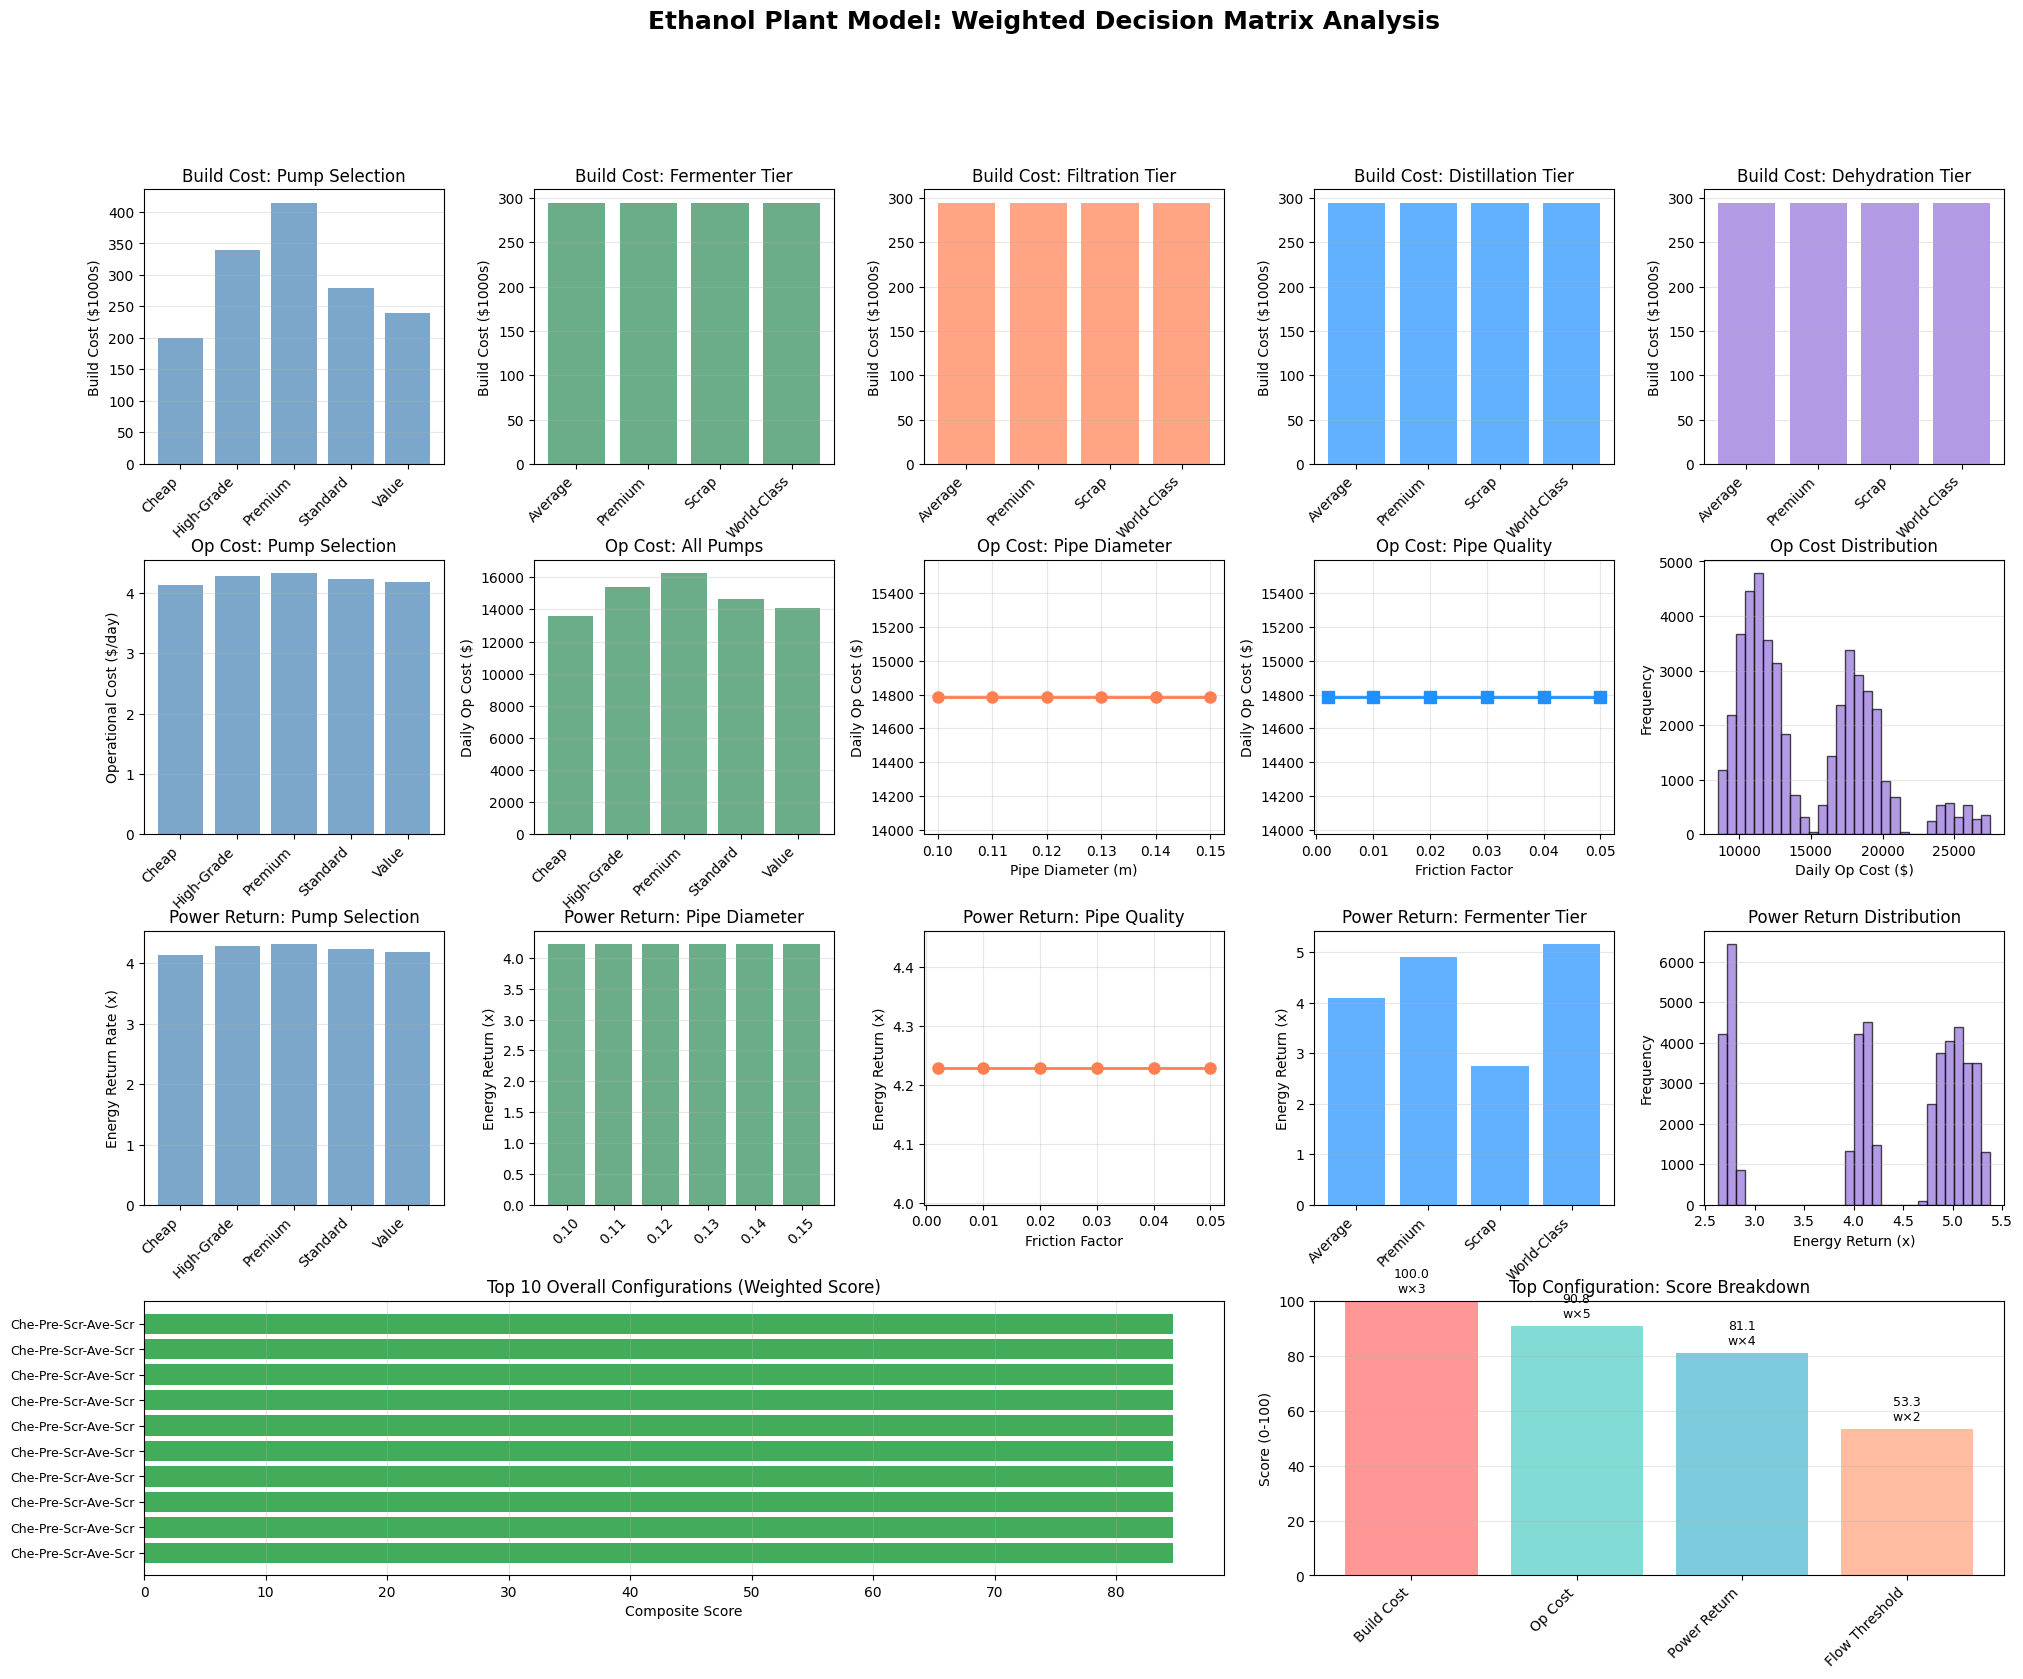


Visualization saved to 'data/decision_matrix_analysis.png'


In [8]:
import os

# Create data folder if it doesn't exist
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"Created '{data_folder}' folder")

# ========================================
# COMPREHENSIVE VISUALIZATIONS: Decision Matrix Analysis
# ========================================

print("\n" + "="*100)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*100)

# Create large figure with multiple subplots
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(4, 5, hspace=0.35, wspace=0.3)
fig.suptitle('Ethanol Plant Model: Weighted Decision Matrix Analysis', fontsize=18, fontweight='bold')

# Helper function to plot processor tier analysis
def plot_processor_analysis(ax, ax2, df_subset, metric_col, title, ylabel1, ylabel2, color1='steelblue', color2='red'):
    """Plot processor tiers with dual axis."""
    if len(df_subset) > 0:
        tiers = ['Scrap', 'Average', 'Premium', 'World-Class']
        x_pos = range(len(tiers))
        
        ax.bar(x_pos, df_subset[metric_col], alpha=0.7, color=color1, label=ylabel1)
        ax2.plot(x_pos, df_subset['energy_return'], 'o-', linewidth=2, markersize=8, 
                color=color2, label=ylabel2)
        
        ax.set_ylabel(ylabel1, color=color1)
        ax2.set_ylabel(ylabel2, color=color2)
        ax.set_title(title)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(tiers, rotation=45)
        ax.tick_params(axis='y', labelcolor=color1)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax.grid(True, alpha=0.3, axis='y')

# ============================================================================
# ROW 1: BUILD COST ANALYSIS
# ============================================================================
print("\nGenerating Build Cost Analysis...")

# Plot 1: Build Cost by Pump
ax1 = fig.add_subplot(gs[0, 0])
pump_data = df.groupby('pump').agg({'facility_cost': 'mean', 'energy_return': 'mean'})
ax1.bar(range(len(pump_data)), pump_data['facility_cost']/1000, alpha=0.7, color='steelblue')
ax1.set_ylabel('Build Cost ($1000s)')
ax1.set_title('Build Cost: Pump Selection')
ax1.set_xticks(range(len(pump_data)))
ax1.set_xticklabels(pump_data.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Build Cost by Fermenter
ax2 = fig.add_subplot(gs[0, 1])
ferm_data = df.groupby('fermenter').agg({'facility_cost': 'mean', 'energy_return': 'mean'})
ax2.bar(range(len(ferm_data)), ferm_data['facility_cost']/1000, alpha=0.7, color='seagreen')
ax2.set_ylabel('Build Cost ($1000s)')
ax2.set_title('Build Cost: Fermenter Tier')
ax2.set_xticks(range(len(ferm_data)))
ax2.set_xticklabels(ferm_data.index, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Build Cost by Filtration
ax3 = fig.add_subplot(gs[0, 2])
filt_data = df.groupby('filtration').agg({'facility_cost': 'mean', 'energy_return': 'mean'})
ax3.bar(range(len(filt_data)), filt_data['facility_cost']/1000, alpha=0.7, color='coral')
ax3.set_ylabel('Build Cost ($1000s)')
ax3.set_title('Build Cost: Filtration Tier')
ax3.set_xticks(range(len(filt_data)))
ax3.set_xticklabels(filt_data.index, rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Build Cost by Distillation
ax4 = fig.add_subplot(gs[0, 3])
dist_data = df.groupby('distillation').agg({'facility_cost': 'mean', 'energy_return': 'mean'})
ax4.bar(range(len(dist_data)), dist_data['facility_cost']/1000, alpha=0.7, color='dodgerblue')
ax4.set_ylabel('Build Cost ($1000s)')
ax4.set_title('Build Cost: Distillation Tier')
ax4.set_xticks(range(len(dist_data)))
ax4.set_xticklabels(dist_data.index, rotation=45, ha='right')
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Build Cost by Dehydration
ax5 = fig.add_subplot(gs[0, 4])
dehyd_data = df.groupby('dehydration').agg({'facility_cost': 'mean', 'energy_return': 'mean'})
ax5.bar(range(len(dehyd_data)), dehyd_data['facility_cost']/1000, alpha=0.7, color='mediumpurple')
ax5.set_ylabel('Build Cost ($1000s)')
ax5.set_title('Build Cost: Dehydration Tier')
ax5.set_xticks(range(len(dehyd_data)))
ax5.set_xticklabels(dehyd_data.index, rotation=45, ha='right')
ax5.grid(True, alpha=0.3, axis='y')

# ============================================================================
# ROW 2: OPERATIONAL COST ANALYSIS
# ============================================================================
print("Generating Operational Cost Analysis...")

# Plot 6: Op Cost by Pump
ax6 = fig.add_subplot(gs[1, 0])
ax6.bar(range(len(pump_data)), pump_data['energy_return'], alpha=0.7, color='steelblue')
ax6.set_ylabel('Operational Cost ($/day)')
ax6.set_title('Op Cost: Pump Selection')
ax6.set_xticks(range(len(pump_data)))
ax6.set_xticklabels(pump_data.index, rotation=45, ha='right')
ax6.grid(True, alpha=0.3, axis='y')

# Similar for other parameters
ax7 = fig.add_subplot(gs[1, 1])
pump_op = df.groupby('pump')['daily_cost'].mean()
ax7.bar(range(len(pump_op)), pump_op, alpha=0.7, color='seagreen')
ax7.set_ylabel('Daily Op Cost ($)')
ax7.set_title('Op Cost: All Pumps')
ax7.set_xticks(range(len(pump_op)))
ax7.set_xticklabels(pump_op.index, rotation=45, ha='right')
ax7.grid(True, alpha=0.3, axis='y')

# Op Cost by Diameter
ax8 = fig.add_subplot(gs[1, 2])
diam_op = df.groupby('diameter')['daily_cost'].mean().sort_index()
ax8.plot(diam_op.index, diam_op.values, 'o-', linewidth=2, markersize=8, color='coral')
ax8.set_xlabel('Pipe Diameter (m)')
ax8.set_ylabel('Daily Op Cost ($)')
ax8.set_title('Op Cost: Pipe Diameter')
ax8.grid(True, alpha=0.3)

# Op Cost by Friction Factor
ax9 = fig.add_subplot(gs[1, 3])
fric_op = df.groupby('friction_factor')['daily_cost'].mean().sort_index()
ax9.plot(fric_op.index, fric_op.values, 's-', linewidth=2, markersize=8, color='dodgerblue')
ax9.set_xlabel('Friction Factor')
ax9.set_ylabel('Daily Op Cost ($)')
ax9.set_title('Op Cost: Pipe Quality')
ax9.grid(True, alpha=0.3)

# Op Cost Distribution
ax10 = fig.add_subplot(gs[1, 4])
ax10.hist(df['daily_cost'], bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
ax10.set_xlabel('Daily Op Cost ($)')
ax10.set_ylabel('Frequency')
ax10.set_title('Op Cost Distribution')
ax10.grid(True, alpha=0.3, axis='y')

# ============================================================================
# ROW 3: POWER RETURN ANALYSIS
# ============================================================================
print("Generating Power Return Analysis...")

# Plot 11: Power Return by Pump
ax11 = fig.add_subplot(gs[2, 0])
ax11.bar(range(len(pump_data)), pump_data['energy_return'], alpha=0.7, color='steelblue')
ax11.set_ylabel('Energy Return Rate (x)')
ax11.set_title('Power Return: Pump Selection')
ax11.set_xticks(range(len(pump_data)))
ax11.set_xticklabels(pump_data.index, rotation=45, ha='right')
ax11.grid(True, alpha=0.3, axis='y')

# Power Return by Diameter
ax12 = fig.add_subplot(gs[2, 1])
diam_return = df.groupby('diameter')['energy_return'].mean().sort_index()
ax12.bar(range(len(diam_return)), diam_return.values, alpha=0.7, color='seagreen')
ax12.set_ylabel('Energy Return (x)')
ax12.set_title('Power Return: Pipe Diameter')
ax12.set_xticks(range(len(diam_return)))
ax12.set_xticklabels([f'{d:.2f}' for d in diam_return.index], rotation=45)
ax12.grid(True, alpha=0.3, axis='y')

# Power Return by Friction
ax13 = fig.add_subplot(gs[2, 2])
fric_return = df.groupby('friction_factor')['energy_return'].mean().sort_index()
ax13.plot(fric_return.index, fric_return.values, 'o-', linewidth=2, markersize=8, color='coral')
ax13.set_xlabel('Friction Factor')
ax13.set_ylabel('Energy Return (x)')
ax13.set_title('Power Return: Pipe Quality')
ax13.grid(True, alpha=0.3)

# Power Return by Fermenter
ax14 = fig.add_subplot(gs[2, 3])
ferm_return = df.groupby('fermenter')['energy_return'].mean()
ax14.bar(range(len(ferm_return)), ferm_return.values, alpha=0.7, color='dodgerblue')
ax14.set_ylabel('Energy Return (x)')
ax14.set_title('Power Return: Fermenter Tier')
ax14.set_xticks(range(len(ferm_return)))
ax14.set_xticklabels(ferm_return.index, rotation=45, ha='right')
ax14.grid(True, alpha=0.3, axis='y')

# Power Return Distribution
ax15 = fig.add_subplot(gs[2, 4])
ax15.hist(df['energy_return'], bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
ax15.set_xlabel('Energy Return (x)')
ax15.set_ylabel('Frequency')
ax15.set_title('Power Return Distribution')
ax15.grid(True, alpha=0.3, axis='y')

# ============================================================================
# ROW 4: COMPOSITE SCORE ANALYSIS
# ============================================================================
print("Generating Composite Score Analysis...")

# Plot 16: Top 10 Composite Scores
ax16 = fig.add_subplot(gs[3, 0:3])
top10_scores = df.nlargest(10, 'composite_score')
config_labels = [f"{row['pump'][:3]}-{row['fermenter'][:3]}-{row['filtration'][:3]}-{row['distillation'][:3]}-{row['dehydration'][:3]}" 
                 for _, row in top10_scores.iterrows()]
colors_gradient = plt.cm.RdYlGn(top10_scores['composite_score'].values / 100)
ax16.barh(range(len(top10_scores)), top10_scores['composite_score'].values, color=colors_gradient)
ax16.set_yticks(range(len(top10_scores)))
ax16.set_yticklabels(config_labels, fontsize=9)
ax16.set_xlabel('Composite Score')
ax16.set_title('Top 10 Overall Configurations (Weighted Score)')
ax16.grid(True, alpha=0.3, axis='x')
ax16.invert_yaxis()

# Plot 17: Score components for top configuration
ax17 = fig.add_subplot(gs[3, 3:5])
top_config = df.nlargest(1, 'composite_score').iloc[0]
scores = [top_config['score_build_cost'], top_config['score_op_cost'], 
          top_config['score_power_return'], top_config['score_flow_threshold']]
labels = ['Build Cost', 'Op Cost', 'Power Return', 'Flow Threshold']
weights = [WEIGHT_BUILD_COST, WEIGHT_OP_COST, WEIGHT_POWER_RETURN, WEIGHT_INPUT_FLOW]
colors_scores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

x_pos = range(len(labels))
bars = ax17.bar(x_pos, scores, alpha=0.7, color=colors_scores)
ax17.set_ylabel('Score (0-100)')
ax17.set_title('Top Configuration: Score Breakdown')
ax17.set_xticks(x_pos)
ax17.set_xticklabels(labels, rotation=45, ha='right')
ax17.set_ylim(0, 100)
ax17.grid(True, alpha=0.3, axis='y')

# Add weight annotations
for i, (bar, score, weight) in enumerate(zip(bars, scores, weights)):
    ax17.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{score:.1f}\nw×{weight}', ha='center', va='bottom', fontsize=9)

# Save visualization to data folder
visualization_path = os.path.join(data_folder, 'decision_matrix_analysis.png')
plt.savefig(visualization_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '{visualization_path}'")

In [9]:
# ========================================
# EXPORT RESULTS TO CSV
# ========================================

print("\n" + "="*100)
print("EXPORTING RESULTS")
print("="*100)

# Create data folder if it doesn't exist
data_folder = 'data'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"Created '{data_folder}' folder")

# Define export paths
csv_path = os.path.join(data_folder, 'decision_matrix_results.csv')
top10_path = os.path.join(data_folder, 'top_10_configurations.csv')
summary_path = os.path.join(data_folder, 'summary_statistics.csv')

# Export full results
df.to_csv(csv_path, index=False)
print(f"\n✓ Full results exported to '{csv_path}'")
print(f"  - Total configurations analyzed: {len(df)}")
print(f"  - Columns: {', '.join(df.columns)}")

# Export top 10 configurations
top10 = df.nlargest(10, 'composite_score')
top10.to_csv(top10_path, index=False)
print(f"\n✓ Top 10 configurations exported to '{top10_path}'")

# Create summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Mean Composite Score', 'Max Composite Score', 'Min Composite Score', 
               'Mean Build Cost', 'Mean Daily Op Cost', 'Mean Energy Return'],
    'Value': [
        f"{df['composite_score'].mean():.2f}",
        f"{df['composite_score'].max():.2f}",
        f"{df['composite_score'].min():.2f}",
        f"${df['facility_cost'].mean():.2f}",
        f"${df['daily_cost'].mean():.2f}",
        f"{df['energy_return'].mean():.2f}x"
    ]
})

summary_stats.to_csv(summary_path, index=False)
print(f"\n✓ Summary statistics exported to '{summary_path}'")

# Display top 10 results
print("\n" + "="*100)
print("TOP 10 CONFIGURATIONS BY COMPOSITE SCORE")
print("="*100)

display_cols = ['composite_score', 'pump', 'fermenter', 'filtration', 'distillation', 
                'dehydration', 'diameter', 'friction_factor', 'facility_cost', 'daily_cost', 'energy_return']

display_df = top10[display_cols].copy()
display_df.columns = ['Score', 'Pump', 'Fermenter', 'Filtration', 'Distillation', 
                      'Dehydration', 'Diameter', 'Friction', 'Build Cost', 'Op Cost', 'Energy Return']

print(display_df.to_string(index=True))

print("\n" + "="*100)
print("EXPORT COMPLETE")
print("="*100)


EXPORTING RESULTS

✓ Full results exported to 'data/decision_matrix_results.csv'
  - Total configurations analyzed: 46080
  - Columns: test_name, pump, fermenter, filtration, distillation, dehydration, diameter, friction_factor, input_flow, ethanol_kg, power_kWh, power_generated_kWh, daily_cost, energy_return, facility_cost, total_cost, threshold_flow, score_build_cost, score_op_cost, score_power_return, score_flow_threshold, composite_score

✓ Top 10 configurations exported to 'data/top_10_configurations.csv'

✓ Summary statistics exported to 'data/summary_statistics.csv'

TOP 10 CONFIGURATIONS BY COMPOSITE SCORE
          Score   Pump Fermenter Filtration Distillation Dehydration  Diameter  Friction  Build Cost       Op Cost  Energy Return
4782  84.654271  Cheap   Premium      Scrap      Average       Scrap      0.15     0.002      200000  10251.739091       4.859693
4783  84.654271  Cheap   Premium      Scrap      Average       Scrap      0.15     0.010      200000  10251.739091   